In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Pull in the extracted label info
#DF was separately generated in a live ipython session, using term expansion detailed in our appendix
df = pd.read_pickle('prr/siderevidencedf.pkl')
df.head()

,Query,Prediction,OnLabel
0,S(naproxen)*S(acute_myocardial_infarction),0.997634,1
1,S(ibuprofen)*S(acute_myocardial_infarction),0.994563,1
2,S(hydralazine)*S(acute_myocardial_infarction),0.992497,0
3,S(isosorbide_dinitrate)*S(acute_myocardial_inf...,0.991378,0
4,S(rofecoxib)*S(acute_myocardial_infarction),0.990010,1


In [3]:
#Dask will allow us to run our average CV runs a little more efficiently, at least on a modest cluster
from dask import compute, delayed
import numpy as np
import pandas as pd
from bitarray import bitarray
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.utils import shuffle
from sklearn.model_selection import LeaveOneOut, StratifiedKFold
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier

def loaddata(inputfile, labelfile):
    tmpvecs = []
    tmpqueries = []
    with open(inputfile, 'r') as infile:
        infile.readline()#skip header row
        for line in infile:
            tmp = line.strip().split('|')
            tmpvecs += [np.asarray(bitarray(tmp[1]), dtype=int)]
            tmpqueries += [tmp[0]]
        tmpdf = pd.DataFrame(np.asarray(tmpvecs))
        tmpdf.columns = [str(x) for x in range(1, np.asarray(tmpvecs).shape[1]+1)]
        tmpdf.insert(0, 'Query', tmpqueries)
    labsdict = dict()
    with open(labelfile,'r') as infile:
        for line in infile:
            tmp = line.strip().split('\t')
            labsdict[tmp[1]] = int(tmp[0])
    tmpdf.insert(1, 'Label', [labsdict[x] for x in tmpqueries])
    return tmpdf

# Leave one out crossvalidation quick test
def lootest(df):
    preds = []
    predprob = []
    reals = []
    vecs = np.asarray(df.iloc[:,2:])
    labels = np.asarray(df.Label)
    for train,test in LeaveOneOut().split(vecs):
        model = LogisticRegression(penalty='l1')
        model.fit(vecs[train], labels[train])
        preds += [model.predict(vecs[test])]
        predprob += [model.predict_proba(vecs[test])[:,1]]
        reals += [labels[test]]
    return(f1_score(reals, preds), roc_auc_score(reals, predprob))

def lootestbyade(df):
    preds = []
    predprob = []
    reals = []
    vecs = np.asarray(df.iloc[:,2:])
    labels = np.asarray(df.Label)
    ades = [x.split('*')[1] for x in df.Query]
    adereals = {x.split('*')[1]:[] for x in df.Query}
    adepredprob = {x.split('*')[1]:[] for x in df.Query}
    adepreds = {x.split('*')[1]:[] for x in df.Query}
    for train,test in LeaveOneOut().split(vecs):
        model = LogisticRegression(penalty='l1')
        model.fit(vecs[train], labels[train])
        preds += [model.predict(vecs[test])]
        adepreds[ades[test]] += [preds[-1]]
        predprob += [model.predict_proba(vecs[test])[:,1]]
        adepredprob[ades[test]] += [predprob[-1]]
        reals += [labels[test]]
        adereals[ades[test]] += [reals[-1]]
    return(f1_score(reals, preds), roc_auc_score(reals, predprob), adepreds, adepredprob, adereals)

def get_average_performance(df, trainfunc):
    aucscores = []
    fscores = []
    for i in range(100):
        tmpf1, tmpauc = trainfunc(df)
        fscores += [tmpf1]
        aucscores += [tmpauc]
    return(np.average(fscores), 2*np.std(fscores), np.average(aucscores), 2*np.std(aucscores))

# Load ESP Data
omop = loaddata('subsetvecs/text/OMOPquery_subset.txt','startlists/OMOPlabsandqueries.txt')
euadr = loaddata('subsetvecs/text/euadr_subset.txt','startlists/euadrreflabsandqueries.txt')

#Load PSI Data
psiomop = loaddata('subsetvecs/text/psiomop_subset.txt', 'startlists/OMOPlabsandqueries.txt')
psieuadr = loaddata('subsetvecs/text/psieuadr_subset.txt', 'startlists/euadrreflabsandqueries.txt')


omoptasks = range(100)

In [4]:
omop.head()

,Query,Label,1,2,3,4,5,6,7,8,...,31991,31992,31993,31994,31995,31996,31997,31998,31999,32000
0,"S(penicillin_v)*S(liver_failure,_acute)",0,0,0,1,1,1,0,1,1,...,1,0,1,0,0,1,0,0,1,1
1,S(stavudine)*S(gastrointestinal_hemorrhage),0,1,0,0,1,1,0,1,1,...,1,1,0,1,0,1,0,0,1,1
2,S(tipranavir)*S(acute_myocardial_infarction),0,1,0,0,1,1,0,1,1,...,0,1,0,1,0,0,1,0,1,1
3,S(prochlorperazine)*S(acute_kidney_insufficiency),0,0,0,1,1,1,0,0,1,...,0,0,1,1,0,0,0,0,1,1
4,S(phentolamine)*S(acute_kidney_insufficiency),0,0,0,0,1,0,0,1,1,...,0,0,1,0,1,0,1,0,1,0


In [5]:
import dask.threaded
omoplootasks = [delayed(lootest)(omop) for x in omoptasks]

In [6]:
import dask.threaded
omoploo = compute(*omoplootasks, get=dask.threaded.get)

In [7]:
omoploo

((0.8957055214723927, 0.958934252386002),
 (0.8996960486322189, 0.9593849416755036),
 (0.9024390243902439, 0.9596500530222694),
 (0.8950617283950617, 0.9593319194061505),
 (0.8990825688073395, 0.9610551431601273),
 (0.8996960486322189, 0.9596500530222694),
 (0.8996960486322189, 0.9617974549310712),
 (0.8957055214723927, 0.9598091198303287),
 (0.8929663608562691, 0.9596500530222694),
 (0.9051987767584098, 0.9604984093319193))

In [8]:
nol = np.asarray(omoploo)
print('Average F1: {:.3f} +/- {:.3f}\nAverage AUC: {:.3f} +/- {:.3f}'.format(np.average(nol[:,0]), 2*np.std(nol[:,0]), np.average(nol[:,1]), 2*np.std(nol[:,1])))


Average F1: 0.901 +/- 0.012
Average AUC: 0.960 +/- 0.002


In [9]:
reps = range(100)
euadrtasks = [delayed(lootest)(euadr) for x in reps]
euadrloo = compute(*euadrtasks, get=dask.threaded.get)

In [10]:
nel = np.asarray(euadrloo)
print('Average F1: {:.3f} +/- {:.3f}\nAverage AUC: {:.3f} +/- {:.3f}'.format(np.average(nel[:,0]), 2*np.std(nel[:,0]), np.average(nel[:,1]), 2*np.std(nel[:,1])))

Average F1: 0.841 +/- 0.016
Average AUC: 0.918 +/- 0.006


In [11]:
reps = range(100)
psieuadrtasks = [delayed(lootest)(psieuadr) for x in reps]
psieuadrloo = compute(*psieuadrtasks, get=dask.threaded.get)
npel = np.asarray(psieuadrloo)

In [12]:
print('Average F1: {:.3f} +/- {:.3f}\nAverage AUC: {:.3f} +/- {:.3f}'.format(np.average(npel[:,0]), 2*np.std(npel[:,0]), np.average(npel[:,1]), 2*np.std(npel[:,1])))

Average F1: 0.742 +/- 0.025
Average AUC: 0.809 +/- 0.015


In [13]:
def lootestbyade(df):
    preds = []
    predprob = []
    reals = []
    vecs = np.asarray(df.iloc[:,2:])
    labels = np.asarray(df.Label)
    ades = [x.split('*')[1] for x in df.Query]
    adereals = {x.split('*')[1]:[] for x in df.Query}
    adepredprob = {x.split('*')[1]:[] for x in df.Query}
    adepreds = {x.split('*')[1]:[] for x in df.Query}
    for train,test in LeaveOneOut().split(vecs):
        model = LogisticRegression(penalty='l1')
        model.fit(vecs[train], labels[train])
        preds += [model.predict(vecs[test])]
        adepreds[ades[test[0]]] += [preds[-1]]
        predprob += [model.predict_proba(vecs[test])[:,1]]
        adepredprob[ades[test[0]]] += [predprob[-1]]
        reals += [labels[test]]
        adereals[ades[test[0]]] += [reals[-1]]
    adef1s = dict()
    adeaucs = dict()
    for i in adepreds:
        adef1s[i] = f1_score(adereals[i], adepreds[i])
        adeaucs[i] = roc_auc_score(adereals[i], adepredprob[i])
    return(f1_score(reals, preds), roc_auc_score(reals, predprob), adef1s, adeaucs)

byadetasks = [delayed(lootestbyade)(omop) for x in reps]
byaderesults = compute(*byadetasks, get=dask.threaded.get)

In [14]:
print('Average F1', np.average([x[0] for x in byaderesults]), 2*np.std([x[0] for x in byaderesults]))
print('Average AUC', np.average([x[1] for x in byaderesults]), 2*np.std([x[1] for x in byaderesults]))
for key in byaderesults[0][2]:
    print(key, np.average([x[key] for x in [x[2] for x in byaderesults]]), 2*np.std([x[key] for x in [x[2] for x in byaderesults]]))
for key in byaderesults[0][3]:
    print(key, np.average([x[key] for x in [x[3] for x in byaderesults]]), 2*np.std([x[key] for x in [x[3] for x in byaderesults]]))

Average F1 0.9004287965396935 0.012131991026905318
Average AUC 0.9603085896076351 0.0017754104490717937
S(liver_failure,_acute) 0.8927642896986658 0.015400148228060335
S(gastrointestinal_hemorrhage) 0.9357801418439715 0.005460992907801402
S(acute_myocardial_infarction) 0.9009008972042709 0.037241783014105
S(acute_kidney_insufficiency) 0.8908915356151711 0.03492606781058893
S(liver_failure,_acute) 0.9199201388888889 0.005496785501433127
S(gastrointestinal_hemorrhage) 0.9339898989898989 0.007551138448484238
S(acute_myocardial_infarction) 0.9793589743589745 0.004499169978889536
S(acute_kidney_insufficiency) 0.9474272486772487 0.004904875343288447


In [15]:
import dask.multiprocessing
psibyadetasks = [delayed(lootestbyade)(psiomop) for x in reps]
psibyaderesults = compute(*psibyadetasks, get=dask.multiprocessing.get)

In [16]:
print('Average F1', np.average([x[0] for x in psibyaderesults]), 2*np.std([x[0] for x in psibyaderesults]))
print('Average AUC', np.average([x[1] for x in psibyaderesults]), 2*np.std([x[1] for x in psibyaderesults]))
for key in psibyaderesults[0][2]:
    print(key, np.average([x[key] for x in [x[2] for x in psibyaderesults]]), 2*np.std([x[key] for x in [x[2] for x in psibyaderesults]]))
for key in psibyaderesults[0][3]:
    print(key, np.average([x[key] for x in [x[3] for x in psibyaderesults]]), 2*np.std([x[key] for x in [x[3] for x in psibyaderesults]]))

Average F1 0.8460683326638139 0.015567297666894618
Average AUC 0.9459260339342523 0.0037755285315525604
S(liver_failure,_acute) 0.838148133649484 0.017798384220547397
S(gastrointestinal_hemorrhage) 0.9280655771405075 0.02307979613264252
S(acute_myocardial_infarction) 0.8152099296782529 0.042720203415058805
S(acute_kidney_insufficiency) 0.8357675507458049 0.04304029046508767
S(liver_failure,_acute) 0.8250868055555557 0.014894295439907007
S(gastrointestinal_hemorrhage) 0.9778724747474747 0.007474864778631834
S(acute_myocardial_infarction) 0.960320512820513 0.007910832423490713
S(acute_kidney_insufficiency) 0.9448544973544973 0.007990950832316608


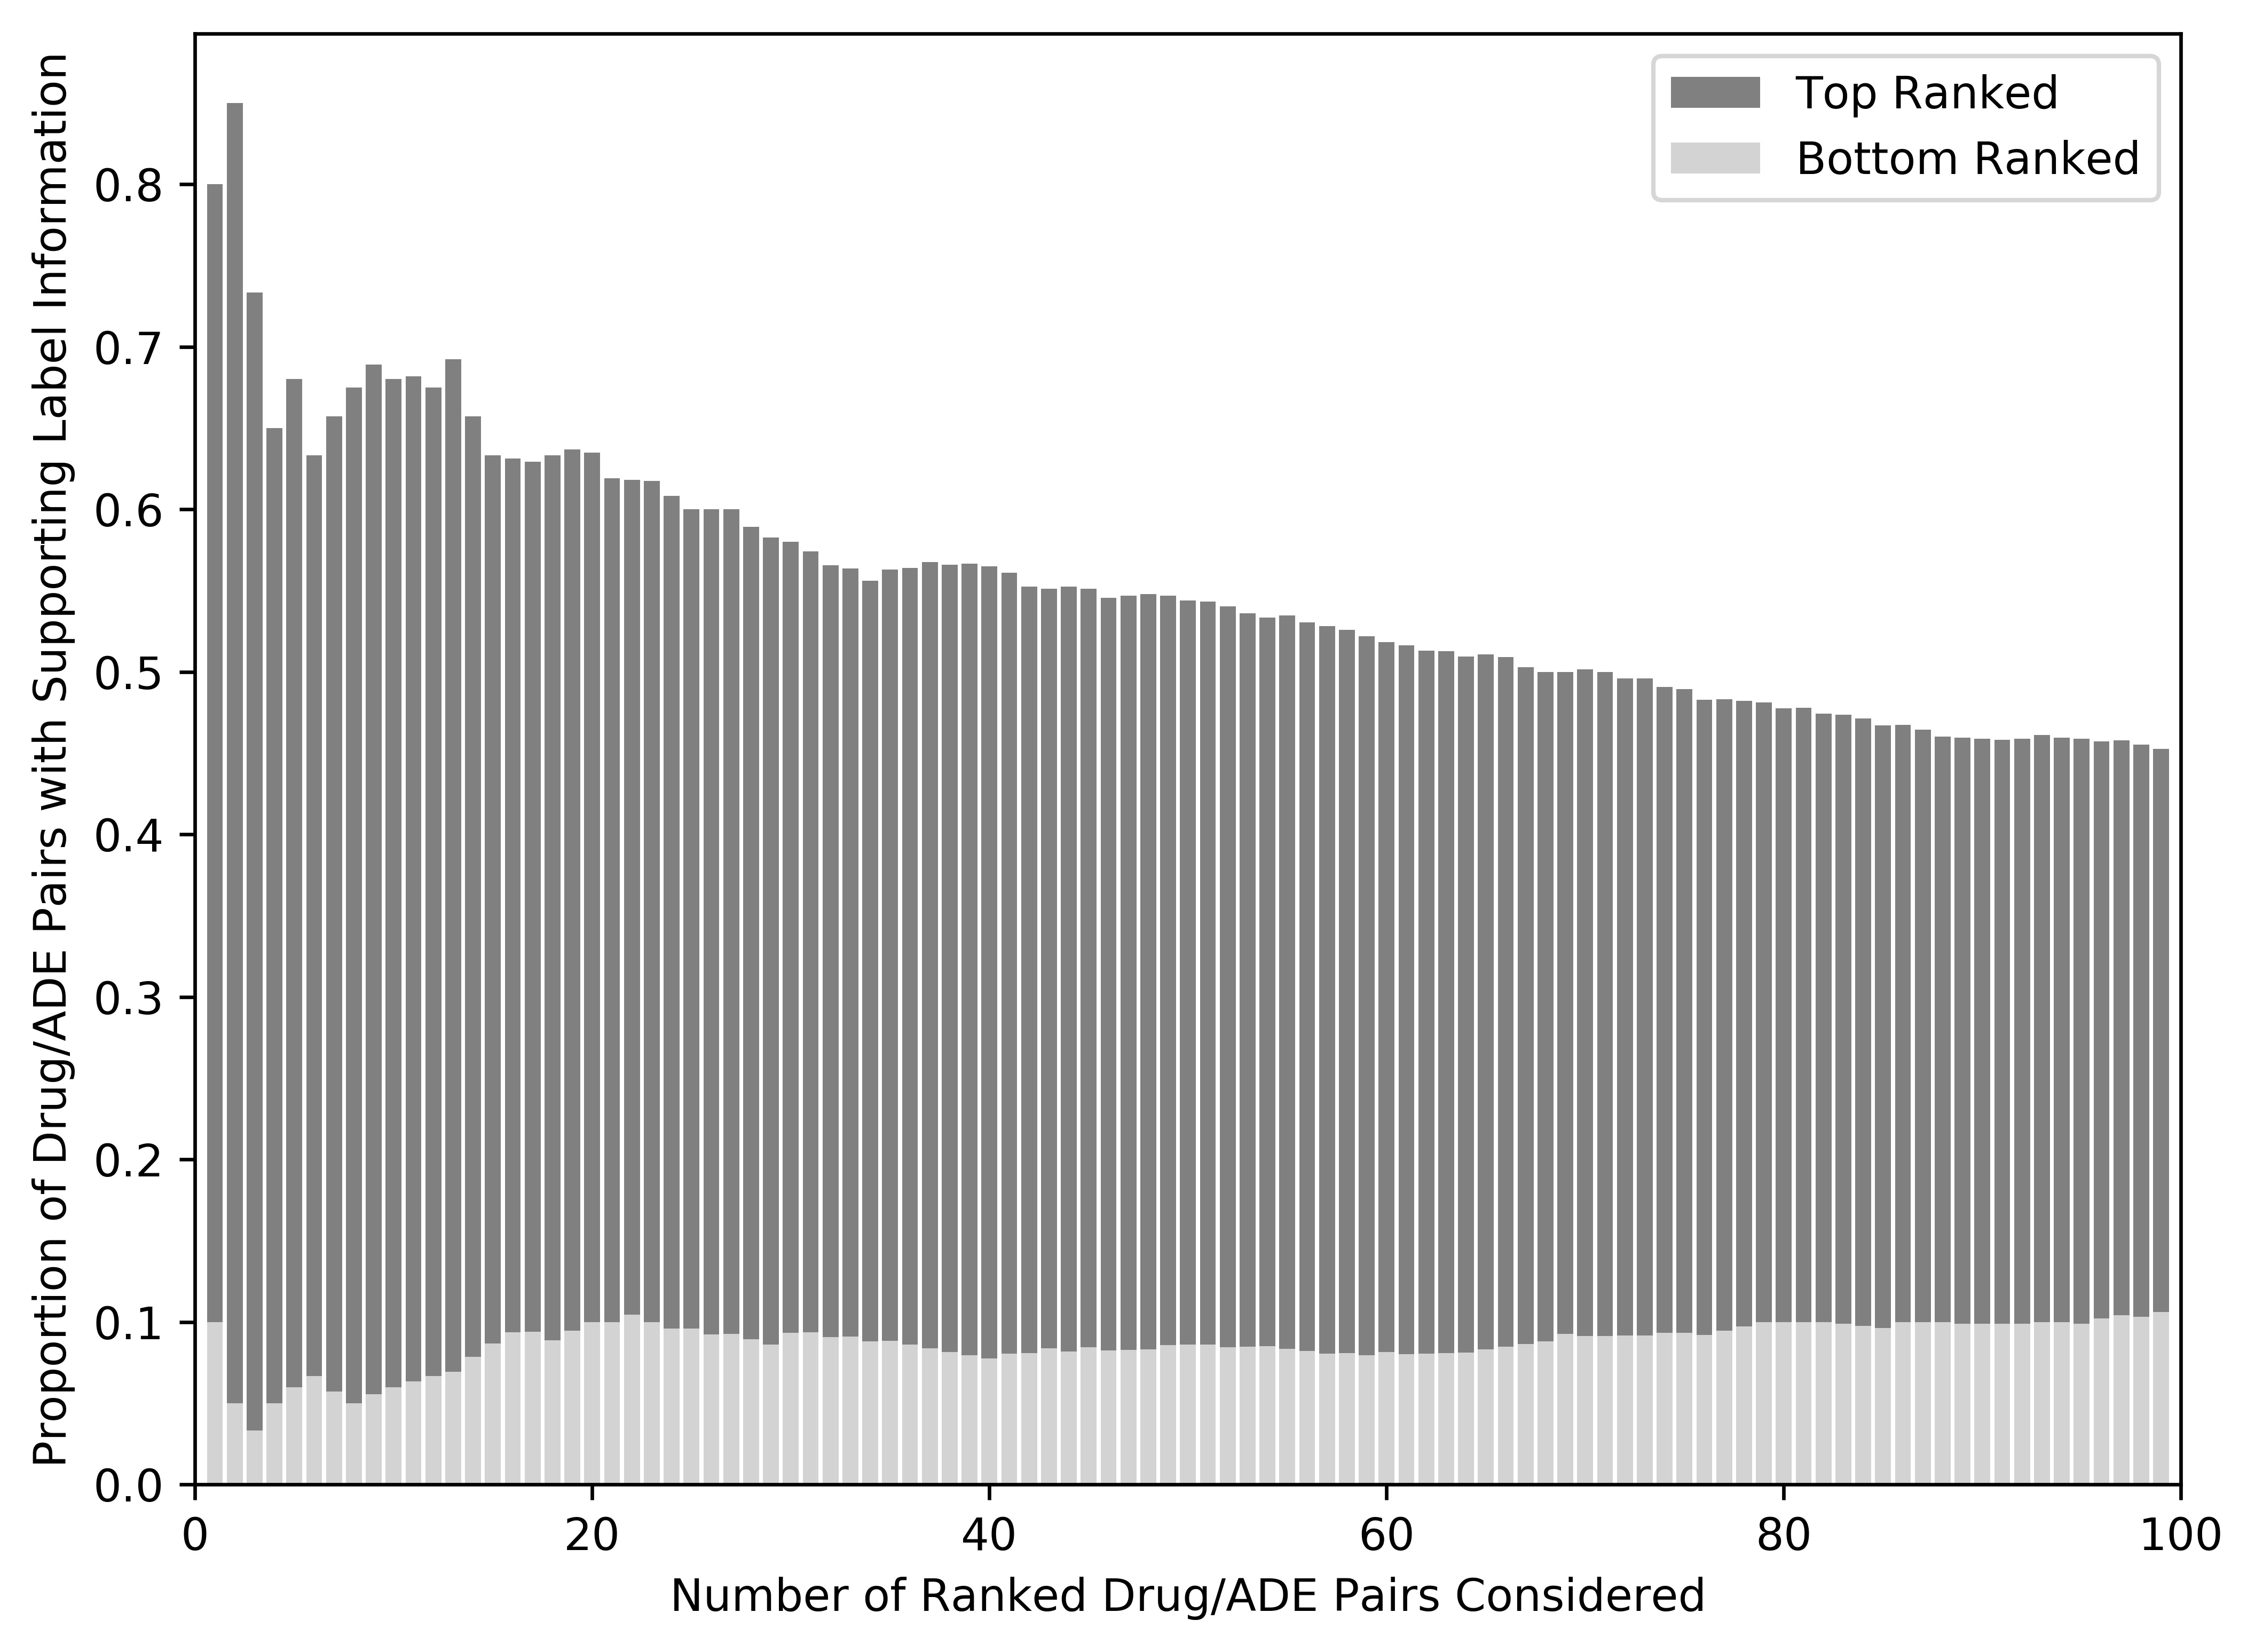

0.45
0.107


In [17]:
#Generate a plot for the top ranked drugs versus the bottom ranked drugs at various cut offs (e.g. top 200 versus bottom 200)
#The bottom axis is off by a factor of 10 because I couldn't figure out how to adjust it appropriately and make it look good,
#so the bottom axis is edited later (the only modification made, and only to make it factually correct)
#At the bottom, print the average enrichment in the top 1k versus bottom 1k (~25% of total predictions for each, 50% combined)
plt.figure(figsize=(8, 6), dpi=600, facecolor='w', edgecolor='k')
plt.bar(range(1,100), [np.average(df.sort_values(by='Prediction', ascending=False).iloc[:x, 2]) for x in range(10, 1000, 10)], 
        label='Top Ranked', color='#808080')
plt.bar(range(1,100), [np.average(df.sort_values(by='Prediction', ascending=False).iloc[-x:, 2]) for x in range(10, 1000, 10)], 
        label='Bottom Ranked', color='#D3D3D3')
plt.ylabel('Proportion of Drug/ADE Pairs with Supporting Label Information')
plt.xlabel('Number of Ranked Drug/ADE Pairs Considered')
plt.legend()
plt.xlim((0,100))
plt.show()
print(np.average(df.sort_values(by='Prediction', ascending=False).iloc[:1000,2]))
print(np.average(df.sort_values(by='Prediction', ascending=False).iloc[-1000:,2]))